Import relevant libraries:

In [31]:
import pandas as pd
import glob #For combining individual files into one dataframe
from pathlib import Path
import matplotlib.pyplot as plt 
from IPython.display import display #For better display of high dimension dataframes. 

## Functions and settings
### Define functions: 


In [32]:
def plot_voyage_on_coastline(voyage_data, coastline_data, padding=0.05):
    """
    Function to plot a voyage's trajectory on a coastline map.

    Parameters:
    - voyage_data (DataFrame): The voyage data containing latitude, longitude, and timestamps.
    - coastline_data (GeoDataFrame): The coastline data (in GeoPandas format).
    - padding (float): Padding around the trajectory for zooming.
    """
    # Ensure the data is sorted by timestamp
    voyage_data = voyage_data.sort_values(by="pos_timestamp", ascending=True, inplace=False)

    # Get min/max latitudes and longitudes from the voyage data to define the zoom area
    min_lon, max_lon = voyage_data['longitude'].min(), voyage_data['longitude'].max()
    min_lat, max_lat = voyage_data['latitude'].min(), voyage_data['latitude'].max()

    # Add some padding to the zoom area
    xlim = (min_lon - padding, max_lon + padding)
    ylim = (min_lat - padding, max_lat + padding)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the coastline
    coastline_data.plot(ax=ax, color='black', linewidth=0.8, label="Coastline")

    # Plot the vessel trajectory
    ax.plot(voyage_data['longitude'], voyage_data['latitude'], marker='o', linestyle='-', color='b', label="Voyage Trajectory")

    # Set axis limits for zooming in
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Voyage Trajectory on Coastline Map")

    # Show legend and grid
    ax.legend()
    ax.grid()

    # Show the plot
    plt.show()

### Define dataframe settings


In [33]:
#Set pandas options to display all columns without collapsing
pd.set_option('display.max_columns', None)  #No column limit
pd.set_option('display.width', None)  #Auto-width adjustment
pd.set_option('display.max_rows', None)  #You can adjust the number of rows displayed

## Load datasets
### Coastline dataset: 



Source: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

<Axes: >

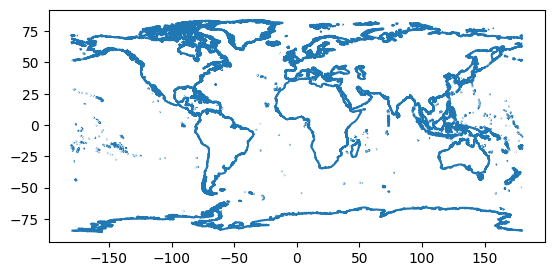

In [50]:
#Load coastline data from Natural Earth 
import geopandas as gpd
coastline = gpd.read_file(Path("./data/ne_10m_coastline/ne_10m_coastline.shp"))
coastline.plot()

### AIS data from Awake
The AIS dataset contains samples from multiple different ships, with each ship identified by the mmsi column. 

When the data is sorted chronologically it is a timeseries of positions for the corresponding ship. 
This timeseries is furthermore, through Awakes processing and not inherently in AIS, annotated with a voyage_id. 
This voyage_id indicates a voyage to/from the port of interest (In this dataset: Valencia) detected by Awakes processing systems. 

A voyage may also entail a shifting inside the port, where the vessel was berthed in port, moved to a different berth inside the port and the moored up again. 
The corresponding meta dataset contains information on the individual voyage_ids, such as departure location & time, arrival location & time and duration.  

Below code black loads the zip files received from Awake, by first defining file name format and then aggregating individual dates/files into one combined dataframe. Done for both Arrivals and Departures and meta data:

In [52]:
#Define the folder and file pattern
folder = Path("./data/mission-voyage-examples")
file_list_arrivals_AIS = list(folder.glob("ESVLC-arrivals-voyage-ais-data-*.parquet.gzip"))
file_list_arrivals_meta = list(folder.glob("ESVLC-arrivals-voyage-metadata-*.parquet.gzip"))
file_list_departures_AIS = list(folder.glob("ESVLC-departures-voyage-ais-data-*.parquet.gzip"))
file_list_departures_meta = list(folder.glob("ESVLC-departures-voyage-metadata-*.parquet.gzip"))

#Create Dataframes of the file types
Arrivals_AIS = pd.concat([pd.read_parquet(file, engine='fastparquet') for file in file_list_arrivals_AIS], ignore_index=True)
Arrivals_Meta = pd.concat([pd.read_parquet(file, engine='fastparquet') for file in file_list_arrivals_meta], ignore_index=True)
Departures_AIS = pd.concat([pd.read_parquet(file, engine='fastparquet') for file in file_list_departures_AIS], ignore_index=True)
Departures_Meta = pd.concat([pd.read_parquet(file, engine='fastparquet') for file in file_list_departures_meta], ignore_index=True)

print('Snippet of AIS dataset: ')
display(Arrivals_AIS.head())

print('Snippet of meta dataset: ')
display(Arrivals_Meta.head())

Snippet of AIS dataset: 


,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
0,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:11:09,UNDEFINED,False,-0.330460,39.426970,360.000000,511,60,False,128.0,0.0,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
1,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:29:09,UNDEFINED,False,-0.330560,39.426960,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
2,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:50:10,UNDEFINED,False,-0.330510,39.426940,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
3,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:00:22,AT_ANCHOR,True,-0.257450,39.395163,236.899994,241,17,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 04:59:02,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01
4,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:15:22,AT_ANCHOR,True,-0.257393,39.395095,194.899994,242,18,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 05:11:03,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01


Snippet of meta dataset: 


,voyage_id,mmsi,departure_time,departure_locode,departure_latitude,departure_longitude,arrival_time,arrival_locode,arrival_latitude,arrival_longitude,prev_voyage_id,next_voyage_id,departed_port_call_id,arrived_port_call_id,duration,arrival_country,arrival_date
0,f4a7d707-95c8-4e3f-93f4-c6000e57853a,224208000,2024-01-15 22:57:24,ESVLC,39.441430,-0.317925,2024-01-15 23:58:36,ESVLC,39.442105,-0.317382,f49ebf4b-71a0-4c81-8317-59d5930c79ed,864c813c-e3d1-4627-9088-750d4bcb9f96,,,3672.0,ES,2024-01-16
1,597c19e1-449b-49a3-9044-62788862926a,225952430,2024-01-15 22:54:55,ESVLC,39.421110,-0.329000,2024-01-16 00:00:00,ESVLC,39.424800,-0.327170,b228aff6-44bb-479c-8cef-ea39fd47b4f0,f01811e2-e6ce-49e6-8877-60d7b326d46e,,,3905.0,ES,2024-01-16
2,ec23c291-f150-4314-a4b7-5834e47c7f7a,255915587,2024-01-15 22:22:37,ESVLC,39.394322,-0.275112,2024-01-16 00:33:06,ESVLC,39.434488,-0.327693,776e4362-e3f9-47ea-97d4-df89891f1204,03f0aad7-0ec9-4f83-a8d4-335b75906a29,,,7829.0,ES,2024-01-16
3,98074eeb-fe2a-4478-8e51-8c9ea2aed4f6,205345130,2024-01-15 22:53:39,ESVLC,39.430230,-0.332620,2024-01-16 00:29:40,ESVLC,39.430240,-0.332640,2737f7cd-015c-45bc-9bd4-d0f2134b917c,e20b07a6-59b9-47f0-92af-c91892a34149,,,5761.0,ES,2024-01-16
4,4c617e21-5ff2-423e-9c81-d4e3b61986dd,255806500,2024-01-15 11:17:21,ESBCN,41.310288,2.150347,2024-01-16 00:39:26,ESVLC,39.439080,-0.325422,115375ca-6147-4c60-910f-13ef7da40f06,2d6446e8-b61b-4da4-aefe-9d949aaac8ec,,,48125.0,ES,2024-01-16


### Vessel Characteristics Data snippet from SPIRE
Below block loads and displays a sample from SPIRE AIS Vessel Database and showcases the types of information available in their Vessel database. This can be seen as a supplement/contrast to the information contained in the Awake AIS dataset. 

In [53]:
SPIRE_sample = pd.read_csv(Path("data/SPIRE_VesselData_Sample/Vessel_Characteristics_Data_Sample_2024.csv"))
display(SPIRE_sample.head())

,imo,shipType,deadweight,netTonnage,builtYear,vesselSubtype,tpcmi,grossTonnage,displacement,liquidCubic98Percent,grainCubicCapacity,teu,holdCount,holdDimensions,hatchCount,hatchDimensions,feu,teuSurplus,teu14t,laneMeters,cars,passengers,reeferCubic,isCoated,isGearless,isSelfUnloading,gearDisplay,gearMaxSwl,reeferPointCount,hullTypeCode,draught,lengthOverall,airDraught,keelToManifold,depth,beamMoulded,berthCount,vesselNameDate,deadYear,shipBuilder,hullNumber,commercialOwner,registeredOwner,keelLaidYear,launchYear,mainEngineCount,mainEngineDesigner,propulsionType,engineDesignation,mcoRpm,mcoKw,mcoHp,propellerCount,propellerType,bowThrusterCount,sternThrusterCount,class1Code,class2Code,classDetails,isIceClassed,iceClass,certificates,tradingCategoryCode,tradingStatusCode,range,bunker1Capacity,bunker1fuelTypeCode,bunker1fuelUnitCode,bunker1tankCount,bunker2Capacity,bunker2fuelTypeCode,bunker2fuelUnitCode,bunker2tankCount,bunker3Capacity,bunker3fuelTypeCode,bunker3fuelUnitCode,bunker3tankCount
0,8869335,VEHICLE_PASSENGER,682.0,800.0,1991.0,Passenger,NaN,2257.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.36,80.30,NaN,NaN,7.20,12.10,NaN,2021-06-16 13:49:32.940,NaN,Perama,NaN,Viteoca,NaN,NaN,NaN,2.0,Mirrlees,Motor,ESL9MK2,NaN,NaN,3998.0,2.0,NaN,1.0,NaN,Bureau Veritas (BV),NaN,NaN,NaN,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6807357,VEHICLE_PASSENGER,880.0,1219.0,1968.0,RoPax,NaN,2452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.0,105.0,900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,71.30,NaN,NaN,5.41,16.31,24.0,NaN,NaN,Meyer Werft,532,STM Transportes,NaN,NaN,NaN,4.0,Deutz,Diesel,SBA8M528,620.0,2332.0,4399.0,NaN,NaN,NaN,NaN,Lloyd's Register (LR),NaN,NaN,1.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7212652,VEHICLE_PASSENGER,3163.0,2072.0,1972.0,NaN,NaN,3797.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,92.0,964.0,NaN,NaN,1.0,NaN,Gearless,NaN,NaN,NaN,4.36,94.01,NaN,NaN,5.62,17.71,NaN,NaN,NaN,Kanda,164,Trans-Asia Shipping Lines,NaN,NaN,NaN,4.0,Niigata,Motor,8MG31EZ,NaN,NaN,10400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9200938,VEHICLE_PASSENGER,2700.0,11481.0,2000.0,Passenger,NaN,30277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.83,181.00,NaN,NaN,8.40,25.46,NaN,NaN,NaN,Atlantique,P31,NCL (Bahamas),NaN,NaN,NaN,2.0,General Electric,Motor,NaN,170.0,41935.0,17675.0,2.0,NaN,NaN,NaN,Lloyd's Register (LR),NaN,NaN,0.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9214446,VEHICLE_PASSENGER,60.0,129.0,2008.0,Passenger,NaN,429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.50,40.40,NaN,NaN,4.00,8.40,NaN,2013-04-30 11:28:04.110,NaN,Shalimar Works (1980),763,SCI,NaN,1999.0,2007.0,2.0,Yanmar,Motor,M200-EN,900.0,2350.0,3196.0,2.0,NaN,NaN,NaN,Indian Register (IR),NaN,NaN,0.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration of Awake AIS data

Below code extracts the individual voyages & MMSIs (ships):

In [ ]:
Arrival_MMSIs = Arrivals_AIS['mmsi'].unique()
Departure_MMSIs = Departures_AIS['mmsi'].unique()
print(f"Number of unique ships: \n\tArrival dataset: {len(Arrival_MMSIs)} \n\tDeparture dataset: {len(Departure_MMSIs)} test")

Arrival_Voyages = Arrivals_AIS['voyage_id'].unique()
Departure_Voyages = Departures_AIS['voyage_id'].unique()
print('Number of unique voyages in arrival dataset and departure dataset: ', len(Arrival_Voyages), len(Departure_Voyages))

Number of unique ships in arrival dataset and departure dataset:  2531 2581
Number of unique voyages in arrival dataset and departure dataset:  43352 43181


In reference to mail from Jussi some of the voyages might include shifting inside the port, we therefore look at the distribution of voyage durations, which is in seconds. We see that some of the voyages have relatively short durations (120 seconds.) which can be caused by e.g. shifting inside the port.

NOTE: It would make sense to consider filtering for voyages above a certain threshold to filter out shiftings and shorter voyages depending on needs, e.g. filter out voyages with a duration less than 43.200 (12 hours) from the metadata.

In [38]:
print('Arrival Voyages duration:')
print(Arrivals_Meta['duration'].describe().apply(lambda x: f"{x:,.2f}"))

print('\nDeparture Voyages duration:')
print(Departures_Meta['duration'].describe().apply(lambda x: f"{x:,.2f}"))


Arrival Voyages duration:
count        43,352.00
mean        234,753.58
std       2,020,141.60
min             120.00
25%           3,874.00
50%           5,849.50
75%          26,031.50
max      82,256,210.00
Name: duration, dtype: object

Departure Voyages duration:
count        43,181.00
mean        231,379.29
std       1,987,138.48
min             120.00
25%           3,884.00
50%           5,899.00
75%          26,930.00
max      82,256,210.00
Name: duration, dtype: object


Below block filters out voyages with a duration less than 12 hours, out of curiosity to see the number of remaining voyages, which is 8916

In [39]:
Long_voyages_Arrival = Arrivals_Meta.query("duration>=43200")
print(Long_voyages_Arrival['duration'].describe().apply(lambda x: f"{x:,.2f}"))
display(Long_voyages_Arrival.head(5))

count         8,916.00
mean      1,111,382.23
std       4,344,742.19
min          43,200.00
25%          82,281.75
50%         184,909.00
75%         536,567.50
max      82,256,210.00
Name: duration, dtype: object


,voyage_id,mmsi,departure_time,departure_locode,departure_latitude,departure_longitude,arrival_time,arrival_locode,arrival_latitude,arrival_longitude,prev_voyage_id,next_voyage_id,departed_port_call_id,arrived_port_call_id,duration,arrival_country,arrival_date
4,4c617e21-5ff2-423e-9c81-d4e3b61986dd,255806500,2024-01-15 11:17:21,ESBCN,41.310288,2.150347,2024-01-16 00:39:26,ESVLC,39.439080,-0.325422,115375ca-6147-4c60-910f-13ef7da40f06,2d6446e8-b61b-4da4-aefe-9d949aaac8ec,,,48125.0,ES,2024-01-16
10,5a70f321-332b-4ad0-b060-46f7502a27e3,277549000,2024-01-14 10:15:07,DZALG,36.764603,3.091983,2024-01-16 01:44:31,ESVLC,39.431325,-0.314428,5cc2441e-b866-482f-a37a-10aa533cf73e,015b8759-dd5a-40ea-a2a1-52c3af9b8fdc,,,142164.0,ES,2024-01-16
13,579f6f0a-36d9-40df-bc2a-085c3d72ea84,636093194,2024-01-14 10:52:08,ESBCN,41.334733,2.166538,2024-01-16 02:22:43,ESVLC,39.456448,-0.291332,721451a5-e518-4c0f-aede-9addb90f62ca,f469e8b7-3463-4c7b-9b8d-4d20ba1ddae6,,,142235.0,ES,2024-01-16
19,e363bca6-8f12-4e77-8bbd-38a0ec3868cb,355194000,2024-01-15 12:56:50,ESARN,41.319917,2.696268,2024-01-16 04:42:20,ESVLC,39.433392,-0.323802,cdb84642-fce3-436d-aee0-cf2186a012a3,2c0e71c7-2f7f-4b3d-8652-1eee35c54ace,,,56730.0,ES,2024-01-16
21,ef3b9cb6-3aec-446e-97d5-60b50f249c2e,229846000,2024-01-14 21:22:10,FRCOS,43.269725,4.992455,2024-01-16 05:48:21,ESVLC,39.447203,-0.315360,966807a6-db4e-4fcd-81d6-d1eba426a7f7,d640212b-6996-4059-b63d-90b7d1c3f31c,,,116771.0,ES,2024-01-16


Check for potential noise and faulty data by looking at describtive statistics of speed and positions:

In [40]:
print("Statistics of speed over ground from Arrival data:")
print(Arrivals_AIS['speed_over_ground'].describe().apply(lambda x: f"{x:,.2f}"))

print("Statistics of speed over ground from Departure data:")
print(Departures_AIS['speed_over_ground'].describe().apply(lambda x: f"{x:,.2f}"))

Statistics of speed over ground from Arrival data:
count    3,311,442.00
mean             2.97
std              6.07
min              0.00
25%              0.00
50%              0.00
75%              0.90
max            102.30
Name: speed_over_ground, dtype: object
Statistics of speed over ground from Departure data:
count    3,785,019.00
mean             2.60
std              5.80
min              0.00
25%              0.00
50%              0.00
75%              0.30
max            102.30
Name: speed_over_ground, dtype: object


Notice that max value for both is 102,3. This is very high, so we will explore that a bit. 

Note: This shows the max value, potentially there could be another value 1-2 knots below which does not show here. The real max speed will have to decided on case-by-case basis, depending on vessel type. I.e. Containerships might sail faster than a tanker, but slower than a speedboat/yacht. 
Below code block tries to filter for speeds above 30 knots and checks the distribution.

In [41]:
#Check for speeds above 30 knots and assess distribution of speeds.
high_speeds = Departures_AIS[Departures_AIS['speed_over_ground'] > 30] 
print(high_speeds['speed_over_ground'].describe())

count    1466.000000
mean       95.889088
std        18.813804
min        30.200000
25%       102.300000
50%       102.300003
75%       102.300003
max       102.300003
Name: speed_over_ground, dtype: float64


Below block filters for the maximum speed and high speed cases (speed>30) and prints the number of vessels with a speed either equal to max or above 30 knots and their MMSIs. 

In [42]:
#Find sample with max speed value
max_speed = Departures_AIS['speed_over_ground'].max()  # Get max value
max_speed_samples = Departures_AIS[Departures_AIS['speed_over_ground'] == max_speed]  #Filter rows
high_speed_samples = Departures_AIS[Departures_AIS['speed_over_ground'] > 30]  #Filter rows


#Print MMSI of the vessels with max speed
print('MMSIs with a max speed equal to the max speed variable (~102.3 knots):')
print('Number of ships: ', len(max_speed_samples['mmsi'].unique()))
print(max_speed_samples['mmsi'].unique())

#Print MMSI of the vessels with high speed
print('MMSIs with a max speed equal to high speed (>30 knots):')
print('Number of ships: ', len(high_speed_samples['mmsi'].unique()))
print(high_speed_samples['mmsi'].unique())


MMSIs with a max speed equal to the max speed variable (~102.3 knots):
Number of ships:  42
[319224700 372497000 225437000 538004913 255806363 538009277 414246000
 215443000 428002000 245921000 352921000 224586000 211323730 636023100
 256938000 225992099 511100824 353968000 636014219 247264700 218441000
 245872000 538003460 255805869 255915661 255803201 268243601 255806346
 477106800 255806494 563143700 224301340 256864000 244985000 241839000
 636018075 355919000 224208000 244150011 636012253 636023024 229877000]
MMSIs with a max speed equal to high speed (>30 knots):
Number of ships:  123
[319224700 372497000 225988759 225996139 225437000 227375680 255806492
 225998087 538004913 225952430 314542000 218847000 225987339 255806363
 538009277 235000177 636093140 538071547 224179490 224050240 247277040
 219022898 203837300 225994605 211163080 225003840 225987892 232048472
 414246000 636017045 224108380 224988680 636016805 223112001 215443000
 428002000 245921000 353728000 352921000 3735170

For exploration we continue with a random MMSI 229877000, which is a container ship.
And MMSI 232036294, which is a highspeed pleasure craft.



In [43]:
Sample_MMSI = 229877000  
subset_samples = Departures_AIS[Departures_AIS['mmsi'] == Sample_MMSI] #Subset for only sample vessel
sample_voyages = subset_samples['voyage_id'].unique() #Find unique voyages
max_speeds_per_voyage = subset_samples.groupby('voyage_id')['speed_over_ground'].max() #Find maxspeed in each voyage
print('Max speeds for each voyage for MMSI 229877000:')
for voyage_id, max_speed in max_speeds_per_voyage.items(): #Print maxspeed for each voyage
    print(f"Voyage ID {voyage_id}: Max Speed = {max_speed}")


Max speeds for each voyage for MMSI 229877000:
Voyage ID 08a9aba9-3f11-459b-90d2-4042da73a392: Max Speed = 8.0
Voyage ID 0a027ed7-0f80-47e7-b822-097e4280cc6e: Max Speed = 6.400000095367432
Voyage ID 3424bc07-7bc6-4af9-a818-feade01b21c6: Max Speed = 8.899999618530273
Voyage ID 50760a8b-6f59-404e-9fa1-91f794e3b947: Max Speed = 12.5
Voyage ID 75007e3b-093e-46a8-81d6-8909ff090589: Max Speed = 20.5
Voyage ID 81c8723e-b955-41b7-8d8d-f919df828c37: Max Speed = 19.700000762939453
Voyage ID 9b645e7d-7eae-4cb9-be7f-1180db917512: Max Speed = 20.100000381469727
Voyage ID bafb2245-d857-4870-9f4a-6a19f431ac81: Max Speed = 8.100000381469727
Voyage ID c147a76d-c08c-46bd-8cc7-29c688d1e59b: Max Speed = 20.5
Voyage ID c6781927-08a6-4242-830c-61c46b25f7a9: Max Speed = 102.30000305175781


In [44]:

noisy_voyage = subset_samples[subset_samples['voyage_id']=="c6781927-08a6-4242-830c-61c46b25f7a9"] #Subset further for the voyage containing the high speed
noisy_voyage = noisy_voyage.sort_values(by='pos_timestamp', inplace=False).reset_index(drop=False)


In general the speeds looks good but the last sample with a max speed of 102.3 needs further exploration. In below block we subset for the samples with the max speed value and surrounding samples and plot them. 

,index,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
268,3699687,c6781927-08a6-4242-830c-61c46b25f7a9,STOPPED,229877000,2024-12-07 17:37:41,UNDER_WAY_USING_ENGINES,False,-4.693837,36.192395,115.099998,227,38,False,-2.0,1.200000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 17:36:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
269,3699688,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 17:51:42,UNDER_WAY_USING_ENGINES,False,-4.686033,36.190748,96.800003,191,39,False,-1.0,2.000000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 17:48:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
270,3700866,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 18:07:52,UNDER_WAY_USING_ENGINES,False,-4.674405,36.190867,82.699997,181,49,False,0.0,2.100000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:06:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
271,3700867,c6781927-08a6-4242-830c-61c46b25f7a9,STOPPED,229877000,2024-12-07 18:17:32,UNDER_WAY_USING_ENGINES,False,-4.667587,36.191875,77.199997,179,29,False,0.0,1.900000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:12:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
272,3700868,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 18:21:52,UNDER_WAY_USING_ENGINES,False,-4.664792,36.192435,75.099998,177,50,False,0.0,2.000000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:18:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
273,3700869,c6781927-08a6-4242-830c-61c46b25f7a9,STOPPED,229877000,2024-12-07 18:27:01,UNDER_WAY_USING_ENGINES,False,-4.661497,36.193218,72.300003,172,59,False,-1.0,1.900000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:24:21,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
274,3700870,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 18:33:21,UNDER_WAY_USING_ENGINES,False,-4.657493,36.194172,74.500000,173,17,False,1.0,2.000000,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:30:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Con

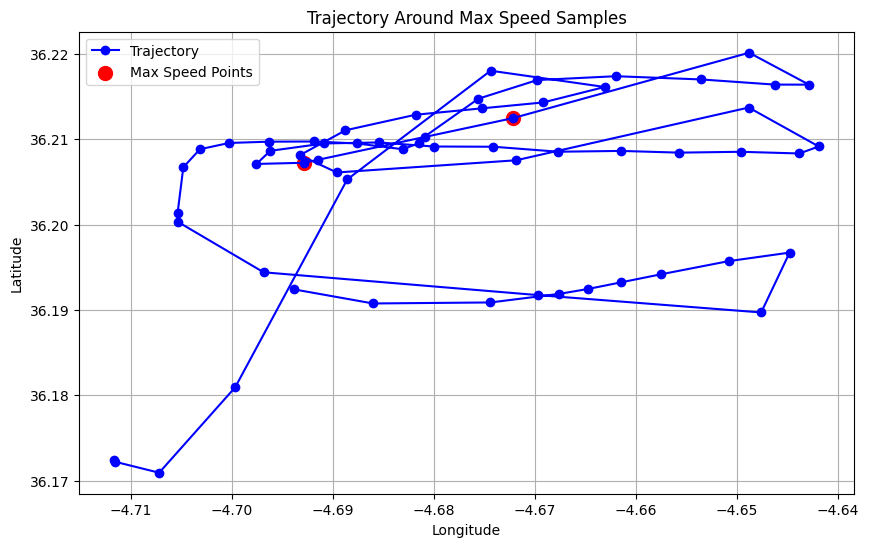

In [45]:
#Find the row where speed_over_ground is max in the faulty voyage
max_speed_sample = noisy_voyage[noisy_voyage['speed_over_ground'] == noisy_voyage['speed_over_ground'].max()]
max_indices = max_speed_sample.index.tolist()#Get all indices of max speed samples
window_size = 30 #Define a window size for viewing surrounding samples

#Collect indices of surrounding samples
surrounding_indices = []
for idx in max_indices:
    start_index = max(0, idx - window_size)  #Ensure we don't go below index 0
    end_index = min(len(noisy_voyage), idx + window_size + 1)  #Ensure we don't exceed DataFrame length
    surrounding_indices.extend(range(start_index, end_index))
surrounding_indices = sorted(set(surrounding_indices)) #Remove duplicates and sort indices
subset_samples = noisy_voyage.iloc[surrounding_indices] #Subset the DataFrame with the selected indices

#Display the DataFrame interactively
display(subset_samples)


#Plot the subset 
plt.figure(figsize=(10, 6))
plt.plot(subset_samples['longitude'], subset_samples['latitude'], marker='o', linestyle='-', color='b', label="Trajectory")

# Highlight max speed samples in red
plt.scatter(max_speed_sample['longitude'], max_speed_sample['latitude'], color='r', s=100, label="Max Speed Points")

# Label axes and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectory Around Max Speed Samples")

# Show legend and grid
plt.legend()
plt.grid()
plt.show()

Looking at the dataframe we see the vessel is sailing at relatively low speeds (1-3 knots) and then suddenly jumps to 102,3 knots. This could be an indication of a noisy data transmission/reception. Looking at the pattern the vessel is sailing it could indicate that vessel is drifting/waiting to enter port etc.

We do the same procedure with MMSI 232036294, the highspeed craft.

In [46]:
Sample_MMSI = 232036294  
subset_samples2 = Departures_AIS[Departures_AIS['mmsi'] == Sample_MMSI] #Subset for only sample vessel
sample_voyages2 = subset_samples2['voyage_id'].unique() #Find unique voyages
max_speeds_per_voyage2 = subset_samples2.groupby('voyage_id')['speed_over_ground'].max() #Find maxspeed in each voyage
print('Max speeds for each voyage for MMSI 232036294:')
for voyage_id, max_speed in max_speeds_per_voyage2.items(): #Print maxspeed for each voyage
    print(f"Voyage ID {voyage_id}: Max Speed = {max_speed}")


Max speeds for each voyage for MMSI 232036294:
Voyage ID d95f4be1-0f53-49dc-92e7-b8a6b570ff5d: Max Speed = 39.5


In [47]:
noisy_voyage2 = subset_samples2[subset_samples2['voyage_id']=="d95f4be1-0f53-49dc-92e7-b8a6b570ff5d"] #Subset further for the voyage containing the high speed (change the voyage id)
noisy_voyage2 = noisy_voyage2.sort_values(by='pos_timestamp', inplace=False).reset_index(drop=False)

Above shows that the high-speed craft has one voyage with a speed exceeding 30 knots. In this voyage the max speed is 39.5 knots. It might seem high, but when googling the vessel and it shows it has a cruising speed and max speed of 40 and 42 knots respectively. The point here is to indicate that what constitutes a excessive/high speed depends on the vessel type and characteristics. 

,index,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
0,2264849,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,PENDING_DEPARTURE,232036294,2024-07-21 16:59:37,UNDEFINED,False,-0.32863,39.45941,360.0,511,60,False,128.0,0.0,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
1,2261844,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,PENDING_DEPARTURE,232036294,2024-07-23 04:13:08,UNDEFINED,False,-0.32867,39.45941,360.0,511,60,False,128.0,0.0,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
2,2261845,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 04:23:06,UNDEFINED,False,-0.31495,39.46075,97.1,511,60,False,128.0,6.8,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
3,2261846,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 04:39:14,UNDEFINED,False,-0.19440,39.51024,61.9,511,60,False,128.0,38.8,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
4,2265680,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 08:17:15,UNDEFINED,False,1.96110,41.14387,47.0,511,60,False,128.0,39.5,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
5,2265681,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 08:42:54,UNDEFINED,False,2.23016,41.31988,28.9,511,60,False,128.0,38.9,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
6,2263811,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 08:59:23,UNDEFINED,False,2.33147,41.41207,27.8,511,60,False,128.0,20.4,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
7,2263812,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 09:23:08,UNDEFINED,False,2.60259,41.56053,62.4,511,60,False,128.0,37.8,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
8,2264970,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-24 08:39:30,UNDEFINED,False,5.24373,43.21829,107.6,511,60,False,128.0,27.0,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
9,2260644,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-24 11:31:08,UNDEFINED,False,6.70700,43.23424,9.7,511,60,False,128.0,37.4,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07


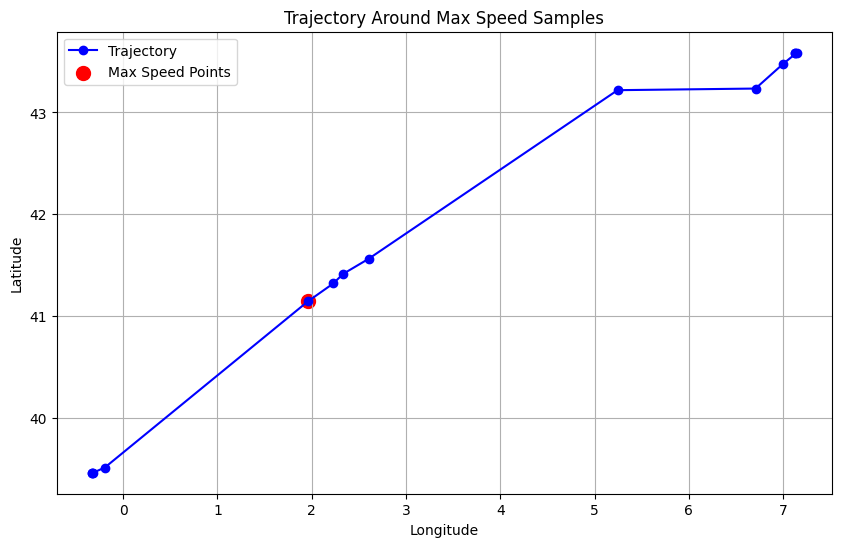

In [48]:
#Find the row where speed_over_ground is max in the faulty voyage
max_speed_sample2 = noisy_voyage2[noisy_voyage2['speed_over_ground'] == noisy_voyage2['speed_over_ground'].max()]
max_indices = max_speed_sample2.index.tolist()#Get all indices of max speed samples
window_size = 50 #Define a window size for viewing surrounding samples

#Collect indices of surrounding samples
surrounding_indices = []
for idx in max_indices:
    start_index = max(0, idx - window_size)  #Ensure we don't go below index 0
    end_index = min(len(noisy_voyage2), idx + window_size + 1)  #Ensure we don't exceed DataFrame length
    surrounding_indices.extend(range(start_index, end_index))
surrounding_indices = sorted(set(surrounding_indices)) #Remove duplicates and sort indices
subset_samples2 = noisy_voyage2.iloc[surrounding_indices] #Subset the DataFrame with the selected indices

#Display the DataFrame interactively
display(subset_samples2)



#Plot the subset 
plt.figure(figsize=(10, 6))
plt.plot(subset_samples2['longitude'], subset_samples2['latitude'], marker='o', linestyle='-', color='b', label="Trajectory")

# Highlight max speed samples in red
plt.scatter(max_speed_sample2['longitude'], max_speed_sample2['latitude'], color='r', s=100, label="Max Speed Points")

# Label axes and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectory Around Max Speed Samples")

# Show legend and grid
plt.legend()
plt.grid()
plt.show()

Below plot shows the two vessels tracks in relation to land.

For the first one we can see it is inside the mediterrenean close the strait of Gibraltar.

For the second ship, the highspeed craft, we see it is sailing a route along the coast. (And across the coast at one point, which is likely due to data gaps and plotting a connecting line.)

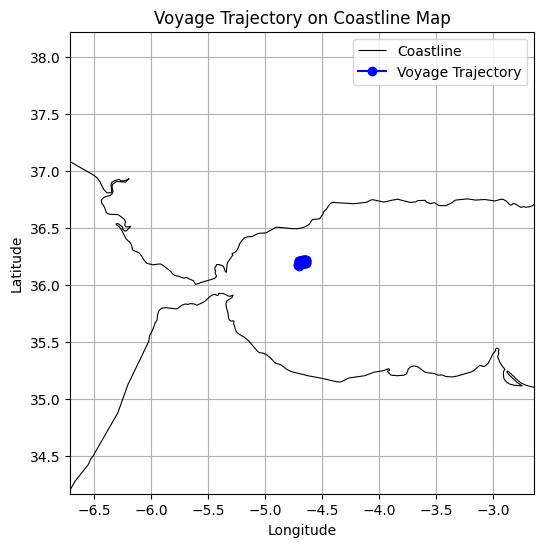

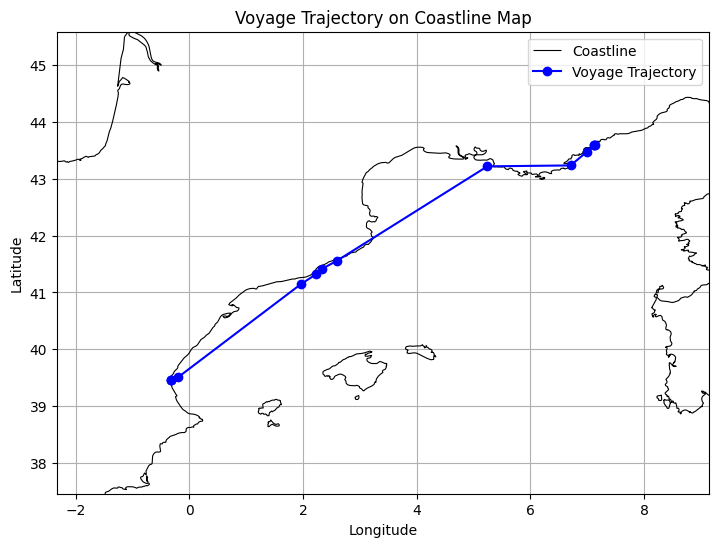

In [49]:
plot_voyage_on_coastline(voyage_data=subset_samples, coastline_data=coastline, padding=2)
plot_voyage_on_coastline(voyage_data=subset_samples2, coastline_data=coastline, padding=2)

Notes: Does the Awake data include the stuff Anastacia needs? The MMSIs they need might be located in the data from Jussi, but chances are likely slim.
